In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# ==========================================
# 1. LOAD DATA
# ==========================================
print("1. Load dataset...")
df = pd.read_csv("abalone.csv")

1. Load dataset...


2. Cleaning data and engineering features...


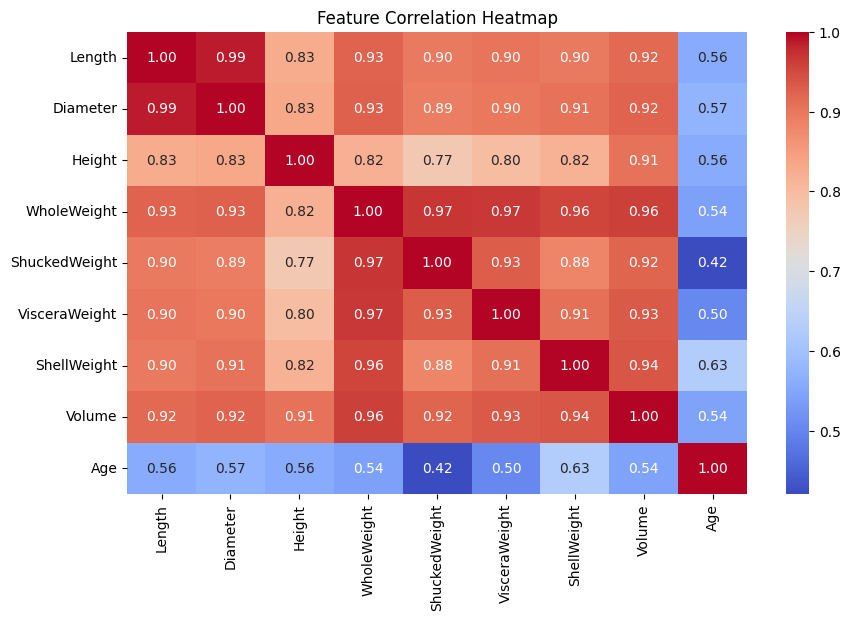

In [ ]:
# ==========================================
# 2. FEATURE ENGINEERING & EDA
# ==========================================
print("2. Cleaning data and engineering features...")
# Remove duplicates
df = df.drop_duplicates()

# Create a 'Volume' feature
df['Volume'] = df['Length'] * df['Diameter'] * df['Height']

# Convert 'Rings' to actual 'Age' and drop the original Rings column
df['Age'] = df['Rings'] + 1.5
df = df.drop(['Rings'], axis=1)

# Plot a Correlation Heatmap to see how features relate
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# ==========================================
# 3. PREPROCESSING
# ==========================================
# One-Hot Encode the 'Sex' column
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

# Define Features (X) and Target (y)
X = df.drop('Age', axis=1)
y = df['Age']

# Standard 80/20 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the numerical data to prevent larger numbers from dominating
# (Fit ONLY on training data to prevent data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# ==========================================
# 4. TRAIN MODELS
# ==========================================
# --- Model 1: Linear Regression ---
print("\n3. Training Linear Regression Model...")
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
predictions_lr = lin_reg.predict(X_test_scaled)

# --- Model 2: Random Forest (Slightly tweaked grid search) ---
print("4. Tuning Random Forest Model...")
rf_regressor = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 250],        # Tweaked from 200 to 250
    'max_depth': [None, 15, 25],       # Tweaked the depth options
    'min_samples_split': [2, 4]        # Tweaked from 5 to 4
}
gsearch = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
gsearch.fit(X_train_scaled, y_train)

optimal_rf = gsearch.best_estimator_
predictions_rf = optimal_rf.predict(X_test_scaled)

print(f"   -> Optimal Parameters Found: {gsearch.best_params_}")


3. Training Linear Regression Model...
4. Tuning Random Forest Model...
   -> Optimal Parameters Found: {'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 250}


In [ ]:
# ==========================================
# 5. EVALUATION METRICS
# ==========================================
results_table = pd.DataFrame({
    'Model Type': ['Linear Regression', 'Random Forest'],
    'R-Squared (R2)': [r2_score(y_test, predictions_lr), r2_score(y_test, predictions_rf)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, predictions_lr)), np.sqrt(mean_squared_error(y_test, predictions_rf))],
    'MAE': [mean_absolute_error(y_test, predictions_lr), mean_absolute_error(y_test, predictions_rf)]
})

print("\n--- Model Performance Summary ---")
print(results_table.round(4).to_string(index=False))
print("---------------------------------")


--- Model Performance Summary ---
       Model Type  R-Squared (R2)   RMSE    MAE
Linear Regression          0.5496 2.2081 1.5808
    Random Forest          0.5389 2.2342 1.5801
---------------------------------


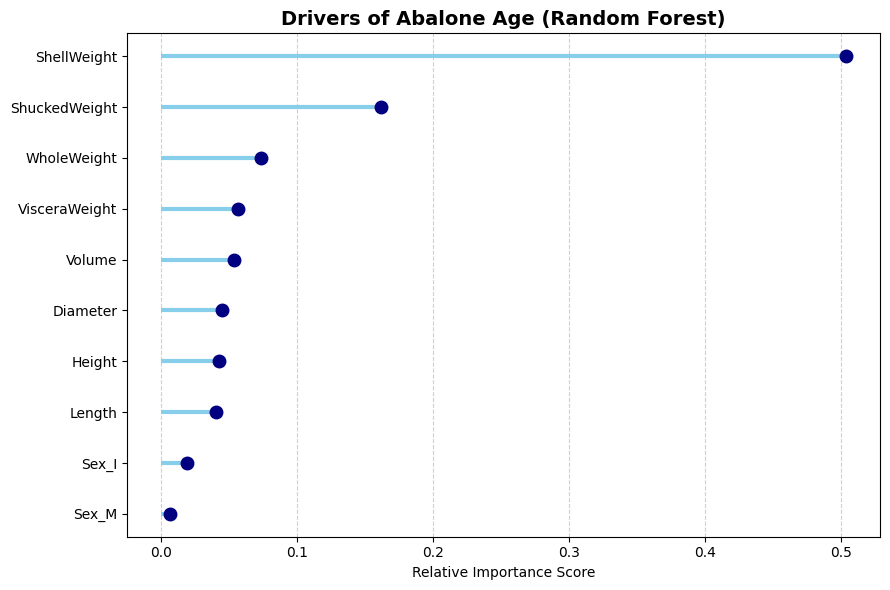

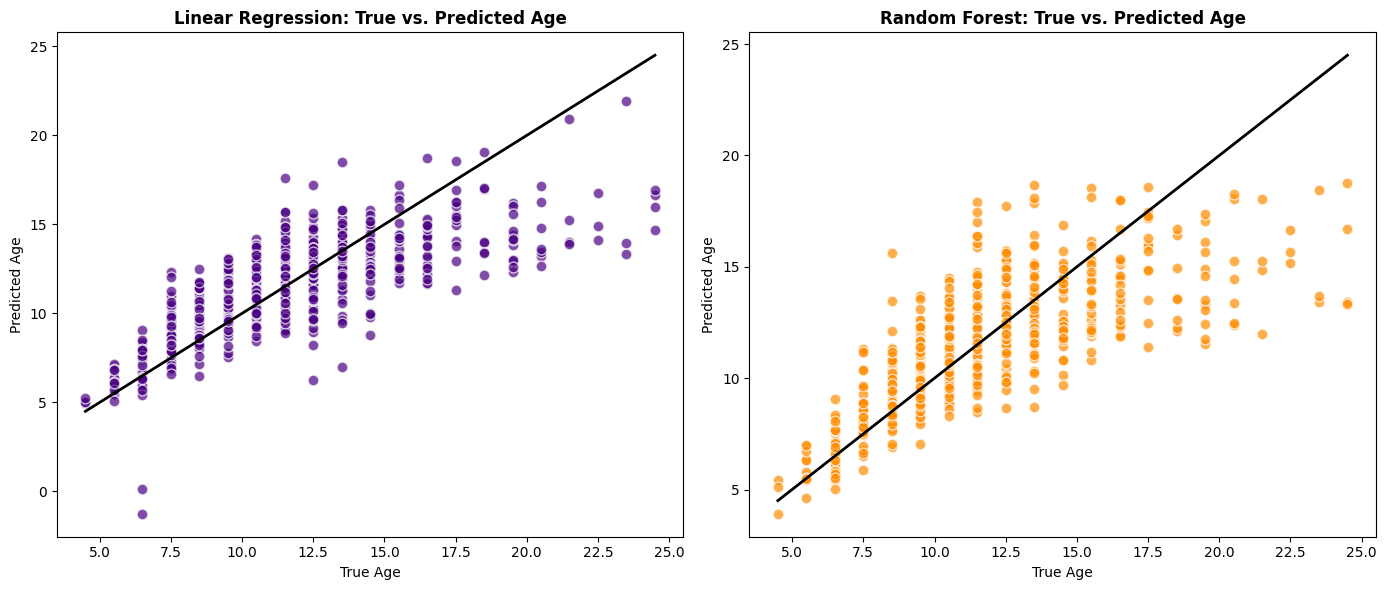

In [ ]:
# ==========================================
# 6. VISUALIZATIONS
# ==========================================
# --- TWEAK 1: Lollipop Chart for Feature Importance ---
importances = optimal_rf.feature_importances_
features = X.columns

# Sort them for plotting
sorted_idx = np.argsort(importances)
sorted_importances = importances[sorted_idx]
sorted_features = features[sorted_idx]

plt.figure(figsize=(9, 6))
# Draw the stems
plt.hlines(y=sorted_features, xmin=0, xmax=sorted_importances, color='skyblue', linewidth=3)
# Draw the lollipop heads
plt.plot(sorted_importances, sorted_features, "o", markersize=9, color='navy')

plt.title('Drivers of Abalone Age (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Relative Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- TWEAK 2: Styled Actual vs Predicted Scatter Plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear Regression Plot
axes[0].scatter(y_test, predictions_lr, edgecolor='white', color='indigo', alpha=0.7, s=60)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', lw=2)
axes[0].set_title("Linear Regression: True vs. Predicted Age", fontweight='bold')
axes[0].set_xlabel("True Age")
axes[0].set_ylabel("Predicted Age")

# Random Forest Plot
axes[1].scatter(y_test, predictions_rf, edgecolor='white', color='darkorange', alpha=0.7, s=60)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', lw=2)
axes[1].set_title("Random Forest: True vs. Predicted Age", fontweight='bold')
axes[1].set_xlabel("True Age")
axes[1].set_ylabel("Predicted Age")

plt.tight_layout()
plt.show()